### **Inputs**

In [1]:
BuyDip = -200 #float(input("Sell if % Decrease Over(negative decimal input): "))
SellProfit = 200 #float(input("Sell if % Increase Over(decimal input): "))
BuyChange = float(input("Buy if % Decrease Over(negative decimal input): "))
SellChange = float(input("Sell if % Increase Over(decimal input): "))
days = int(input("Days to take avg over: "))

### **data organization and initial analysis**

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# importing data set
df = pd.read_csv('Bitcoin Historical Data.csv')

# fixing dataset so that it can be interpreted by the model
df['Price'] = df['Price'].str.replace(',','')
df['Open'] = df['Open'].str.replace(',','')
df['High'] = df['High'].str.replace(',','')
df['Low'] = df['Low'].str.replace(',','')
df['Change %'] = df['Change %'].str.replace('%', '')

df['Price'] = df['Price'].astype(float)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)
df['Change %'] = df['Change %'].astype(float)

df['Vol.'] = df['Vol.'].str.replace(',','')
df['Vol.'] = df['Vol.'].str.replace('K','')
df['Vol.'] = df['Vol.'].str.replace('M','')
df['Vol.'] = df['Vol.'].str.replace('B','')
df['Vol.'] = df['Vol.'].astype(float)
df['Vol.'] = df['Vol.'] * 1000

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

df = df.reset_index(drop=True)

df['Fake_Index'] = np.array([i for i in range(0,len(df))])

df['Change %'] = df['Change %'] / 100

#df['Fake_Index'] = np.array([i for i in range(5,len(df))])
#calculate 5-day moving avg
df['MAD'] = df['Price'].rolling(window=days).mean()

buy_sell = []
position = 0

for i in range(len(df)):
    if i < days-1:
        # For the first few rows where SMA is not available
        buy_sell.append('Pass')
        df.loc[i, 'MAD'] = 0
        continue
        
#Make sure the buy fits within the 5-day moving avg
for i in range(days-1, len(df)):
    price = df.loc[i, 'Price']
    sma5 = df.loc[i, 'MAD']

    avg = ((price - sma5)/sma5)

    if pd.isna(sma5):
        buy_sell.append('Pass')
        continue
        
    # logic to determine whether a user should have bought or sold on this given day, originally derived later in code
    if position == 0 and (avg < BuyChange):
        position = 1 # Buy Bitcoin
        #print((price - sma5)/sma5)
        buy_sell.append(('Buy'))
    elif position > 0 and (avg > SellChange):  
        position = 0 # Sell Bitcoin
        #print((price - sma5)/sma5)
        buy_sell.append(('Sell'))
    else:
        buy_sell.append('Pass') #hold do nothing

df['BuySell'] = buy_sell
df = df[['Fake_Index', 'Date', 'Open', 'High', 'Low', 'Vol.', 'MAD', 'Price', 'BuySell']]

/Users/jamesmarini/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0.5, 1.0, 'BTC Price vs Time')

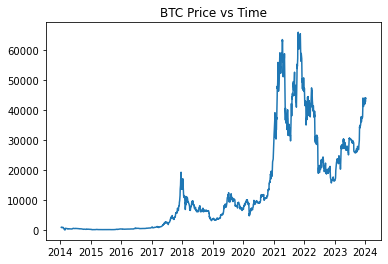

In [8]:
plt.plot(df['Date'], df['Price'])
plt.title('BTC Price vs Time')

### **modeling**

In [3]:
X = df[['Fake_Index', 'Open', 'High', 'Low', 'Vol.', 'MAD']] # features (can be changed, r^2 doesn't change much though)
y = df['Price'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.50)

model = LinearRegression() # linearity of dataset made it pretty easy to use a linear model to predict the prices just based on the opening and volume that day
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(r2_score(y_test, y_pred))

0.9995677177365714


In [4]:
y_pred = pd.Series(y_pred)
y_test = pd.Series(y_test)

train_data = pd.concat([X_train,y_train], axis=1)
train_data.drop(columns='Fake_Index', inplace=True)

orig_index = y_test.index.to_list()
y_test.reset_index(drop=True, inplace=True)

results = pd.concat([y_pred,y_test], axis=1, ignore_index=True)
results['Index'] = orig_index
results.set_index('Index', inplace=True)

results_new = pd.concat([results,X_test], axis=1)
results_new.rename(columns={0:'Predicted'}, inplace=True)
results_new.rename(columns={1:'Actual'}, inplace=True)

final = pd.merge(results_new, df['Date'], left_index=True, right_index=True, how='inner')
final.drop(columns='Fake_Index', inplace=True)

final = final.sort_values('Date')
final = final.reset_index(drop=True)

### **logic to determine whether to buy or sell for new predicted prices**

In [5]:
buy_sell_actual = []
final.rename(columns={'Predicted':'Price'}, inplace=True)


for i in range(len(final)):
    if i < days-1:
        # For the first few rows where SMA is not available
        buy_sell_actual.append('Pass')
        continue
        
#Make sure the buy fits within the 5-day moving avg
for i in range(days-1, len(final)):
    price = final.loc[i, 'Price']
    sma5 = final.loc[i, 'MAD']

    if sma5 == 0:
        buy_sell_actual.append('Pass')
        continue
        
    # logic to determine whether a user should have bought or sold on this given day, originally derived later in code
    if position == 0 and (((price - sma5) / sma5) <= BuyChange):
        position = 1 # Buy Bitcoin
        buy_sell_actual.append('Buy')
    elif position == 0 and (((price - sma5) / sma5) <= BuyChange):
        position = 1 # Buy Bitcoin
        buy_sell_actual.append('Buy')
    elif position > 0 and (((price - sma5) / sma5) >= SellChange):  
        position = 0 # Sell Bitcoin
        buy_sell_actual.append('Sell')
    else:
        buy_sell_actual.append('Pass') #hold do nothing
        
#for i in range(len(final)):
    #if (final['Predicted'].iloc[i] > final['Open'].iloc[i]) and (abs(final['Predicted'].iloc[i] - final['Open'].iloc[i]) / final['Open'].iloc[i] > SellChange):
        #buy_sell_pred.append('sell')
    #else:
       # buy_sell_pred.append('buy')
    
    #if final['Actual'].iloc[i] > final['Open'].iloc[i] and (abs(final['Predicted'].iloc[i] - final['Open'].iloc[i]) / final['Open'].iloc[i] > SellChange):
       # buy_sell_actual.append('sell')
    #else:
        #buy_sell_actual.append('buy')
final['BuySell'] = buy_sell_actual

final = final[['Date', 'Open', 'High', 'Low', 'Vol.', 'MAD', 'Price', 'BuySell']]
df.drop(columns=['Fake_Index'], inplace=True)

df = df[~df['Date'].isin(final['Date'])].reset_index(drop=True)

#final.rename(columns={'BuySell_actual':'BuySell'}, inplace=True)


### **Data Organization**

In [6]:
actual_advice = df
predicted_buy_sell_advice = final
final.to_csv("main_data.csv", index = False)
df.to_csv("test_data.csv", index = False)